In [1]:
# --- my modules
from sample_selection import sample_selection
from proposed_algorithm import domain_invariant_unsupervised_sample_selection as diuss 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [3]:
mat_filename = "./1Data_Tot.mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)
type(data_mat)
data_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SET', 'Time_Sample_Tot', 'Time_White_Tot', 'Time_Dark_Tot', 'Refl_Sample_Tot', 'Trans_Sample_Tot', 'Refl_White_Tot', 'Trans_White_Tot', 'Refl_Dark_Tot', 'Trans_Dark_Tot', 'Refl_Tot', 'Trans_Tot', 'Time_Milk_Tot', 'Cow_ID_Tot', 'Milk_yield_Tot', 'Time_PrevMilk_Tot', 'Milk_Interv_Tot', 'Fat_Tot', 'Prot_Tot', 'Lact_Tot', 'Urea_Tot', 'SCC_Tot', 'pathFolder'])

### <span style="color:#00BDFF">Milk Dataset</span>

In [4]:
x0 = data_mat["Trans_Tot"]
#y0 = np.concatenate((data_mat["Fat_Tot"], data_mat["Prot_Tot"], data_mat["Lact_Tot"]), axis = 1)
y0 = data_mat["Lact_Tot"]
n0 = x0.shape[0]

all_samples = np.arange(n0)
complete_samples = np.where(np.isnan(y0).sum(axis=1) == 0)[0]

x = x0[complete_samples,:]
y = y0[complete_samples,:]
n = x.shape[0]
week = data_mat["SET"][complete_samples]

x_w1 = x[(week == 1).flatten(),:]
y_w1 = y[(week == 1).flatten(),:]
x_w2 = x[(week == 3).flatten(),:]
y_w2 = y[(week == 3).flatten(),:]

n_w2 = x_w2.shape[0]

# use only week 1 as calibration  and week 2 as test set  and lactose as Y variable

### <span style="color:#00BDFF">Setting calibration and test datasets</span>

In [5]:
x_all = x_w1 
print(x_all.shape)
y_all = y_w1
print(y_all.shape)

x_test = x_w2 
print(x_test.shape)
y_test = y_w2
print(y_test.shape)

(316, 256)
(316, 1)
(79, 256)
(79, 1)


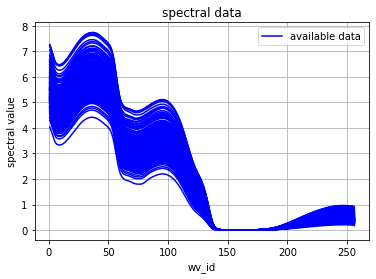

In [6]:
# visualize data
wv_range = np.arange(1,x_all.shape[1]+1) 
plt.plot(wv_range,x_all[0], c = "blue", label = "available data") #(Row 1)
plt.plot(wv_range,x_all.T, c = "blue") #.T is the transpose matrix (Column 1)
plt.xlabel("wv_id")
plt.ylabel("spectral value")
plt.title("spectral data")
plt.legend()
plt.grid()
plt.show()

In [7]:
# initial pca for exploratory analysis
pca_mu = x_all.mean(axis=0)  # mean(axis=0) is an array with the mean per column

X_c = x_all - pca_mu #Mean centering X_initial
X_c_t = np.ascontiguousarray(X_c.transpose()) 
cov_X = X_c_t.dot(X_c)/X_c.shape[0] # ([X_c^T]*[[X_c]) / n ; 
svd_cov_X = np.linalg.svd(cov_X) # Singular Value Decomposition

chosen_pc = 20 #sugested number 

pc_loadings = svd_cov_X[0][:,0:chosen_pc] # first 25 coulums from left eigenvectors U
tscores = (x_all - pca_mu).dot(pc_loadings) #X centered * Loadings
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_all - x_all_predicted,2),axis=1) # Mean per row of (Xi -Xp)^2
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T)) 
#Dig( tscores(155,10)* Dia(1/SVD_Cov_X(650,1))*tscores^T)

print("proportion of variance first pc's: ",np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),6)[0:chosen_pc])
# Eigenvalue(i)/Sum(Eigenvalues)
# Eigenvalues = expalined variance

proportion of variance first pc's:  [9.93616e-01 5.75800e-03 4.31000e-04 1.36000e-04 3.30000e-05 1.10000e-05
 8.00000e-06 3.00000e-06 2.00000e-06 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]


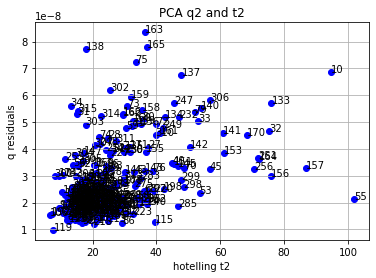

In [8]:
plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()

plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.title("PCA q2 and t2")
plt.show()

In [ ]:
# --- observations to carry for unsupervised sample selection if necessary
#samples_initial_id = np.arange(0,len(x_all))
#drop_obs = [10,55,157] 
#keep_obs = [ii for ii in range(x_all.shape[0]) if ii not in drop_obs]

#x_all_keep = np.delete(x_all, obj = drop_obs, axis=0)
#samples_all_id = samples_initial_id[keep_obs]

#y_all_keep = np.delete(y_all, obj = drop_obs, axis=0)

#print(x_all_keep.shape)
#print(y_all_3.shape)

In [ ]:
#Exporting calibration data to use in R
CAL_X= pd.DataFrame(x_all)
CAL_X.to_excel('1x_all_milk.xlsx', sheet_name='sheet1', index=False)
CAL_X

# <span style="color:#00BDFF">unsupervised sample selection</span>

In [8]:
# --- determine optimal complexity
d = 16 # number of lv
n_sel = 60
a = 20 # number of pc 

print("n: ", n_sel)
print("a: ", a)

n:  60
a:  20


In [9]:
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection

## Z matrix for Diuss Method

In [10]:
sub_samples = diuss.sub_matrix(x_matrix = x_all, num_samples=n_sel)
Z=sub_samples[0]
X_minus_Z=sub_samples[1]
Z_samples=sub_samples[2]
X_minus_Z_samples=sub_samples[3]

Z= element [0] dimetion: (60, 256) numpy.ndarray
Y= element [1] dimetion: (256, 256) numpy.ndarray
Zsamples= element [2] length: 60 numpy.ndarray
Ysamples= element [3] length: 256 numpy.ndarray


## State of the art Methods

In [12]:
# The DOE selection method was performed in R using PCA and optFederov functions
# The DOE selection method was performed in R using PCA and optFederov functions
DOE = [ 3, 10, 12, 27, 32, 33, 40, 43, 45, 53, 55, 64, 70, 73, 75, 
        79, 84, 134, 135, 137, 140, 141, 142, 143, 145, 151, 153, 156, 
        157, 161, 163, 164, 165, 170, 185, 198, 203, 212, 218, 220, 223, 
        240, 242, 247, 249, 250, 251, 256, 269, 271, 275, 281, 282, 285, 
        296, 298, 299, 302, 306, 310]


DOE = np.array(DOE)
DOE.shape

(60,)

In [15]:
Z_DOE= np.zeros(len(x_all),dtype=int)

for i in range(len(Z_DOE)):  
    if i in DOE:
        Z_DOE[i] = 1
Z_DOE

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,

In [16]:
# --- select samples

my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores()

selected_sets = {}

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout=n_sel, fixed_samples=None, use_pca_scores=True,distance_metric='mahalanobis')
selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , use_pca_scores=True, distance_metric='euclidean', linkage = "complete")
selected_sets["all_samples"] = np.full(len(x_all), 1, dtype=int)
selected_sets["DOE"] = Z_DOE

## Diuss Method

In [17]:
#Diuss using max sigmas from SVD
best_max=diuss.diuss_max(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)
#Diuss using sum of sigmas from SVD
best_sum=diuss.diuss_sum(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)

In [19]:
selected_sets["diuss_max"] = best_max[5]
selected_sets["diuss_sum"] = best_sum[5]

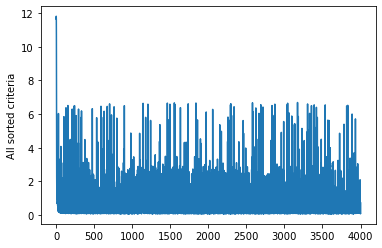

In [20]:
#The criterion shows convergence diuss_max
diuss.crit_behavior(all_crit = best_max[4])

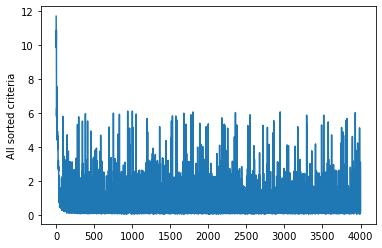

In [21]:
#The criterion shows convergence diuss_sum
diuss.crit_behavior(all_crit = best_sum[4])

In [22]:
print("KS: ",selected_sets["ks_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["ks_sample"]))
print("Duplex: ",selected_sets["duplex_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["duplex_sample"]))
print("puch_sample: ",selected_sets["puch_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["puch_sample"]))
print("clus_sample: ", selected_sets["clus_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["clus_sample"]))
print("diuss_max:",selected_sets["diuss_max"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_max"]))
print("diuss_sum:",selected_sets["diuss_sum"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_sum"]))
print("DOE:",selected_sets["DOE"],"total_samples:",diuss.count_of_ones(array = selected_sets["DOE"]))
print("all_samples:",selected_sets["all_samples"],"total_samples:",diuss.count_of_ones(array = selected_sets["all_samples"]))

KS:  [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0
 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1
 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0] total_samples: 60
Duplex:  [1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0
 0 0 0 1 0 0 0 1 0 1 0 0 0

In [23]:
def sample_list(method_samples):
    l = len(method_samples)
    r=np.zeros((), dtype=int)

    for i in range(l):
        if method_samples[i] == 1:
            r=np.append(r,i)
    r=r[1:] # To eleiminate the first 0 from np.Zeros
    return(r)

In [24]:
Ks = sample_list(method_samples=selected_sets["ks_sample"])
dup = sample_list(method_samples=selected_sets["duplex_sample"])
puch = sample_list(method_samples=selected_sets["puch_sample"])
clus = sample_list(method_samples=selected_sets["clus_sample"])
d_max = sample_list(method_samples=selected_sets["diuss_max"])
d_sum = sample_list(method_samples=selected_sets["diuss_sum"])

In [25]:
# Samples ID from 0 to 315 for a total n=316
print("ks")
print(Ks)
print("dup")
print(dup)
print("puch")
print(puch)
print("clus")
print(clus)
print("d_max")
print(d_max)
print("d_sum")
print(d_sum)
print("DOE")
print(DOE)

ks
[  1  10  23  27  32  33  40  45  53  55  63  70  73  75  76  79  80 101
 115 119 134 136 137 140 141 142 143 145 151 153 154 157 161 162 164 165
 169 170 171 220 240 247 249 250 251 252 256 271 275 282 283 285 288 290
 295 298 299 302 306 312]
dup
[  0   1   3  10  24  32  33  39  40  43  50  55  59  63  72  73  75  76
  78  79  81 101 115 137 139 142 143 146 151 155 157 162 163 166 181 191
 194 212 218 220 227 232 237 238 239 248 249 251 252 258 269 275 282 283
 285 288 298 310 313 314]
puch
[  1   8  10  12  23  27  32  33  40  45  48  53  55  64  70  75  76  79
 101 115 134 136 137 139 140 141 142 143 145 151 153 157 161 162 164 165
 170 171 191 219 220 238 240 247 249 250 251 252 256 269 275 281 282 285
 297 298 299 306 310 312]
clus
[  8  10  15  16  22  25  29  46  48  51  55  58  59  70  76  79  85  91
 104 113 115 118 123 131 134 138 141 147 149 154 156 157 161 168 169 170
 181 182 184 189 193 196 198 201 215 216 219 221 229 232 238 240 250 259
 271 285 287 295 299 313]
d_m

In [29]:
# --- select one sample set for cal and eigenevaluation
svd_methods = {} # dictionary
# [] is a list

for method_name in selected_sets.keys():    

    selected_cal_set = selected_sets[method_name].copy()

    # --- evaluate selected cal set: S matrix eigen decomp

    
    x_selected = x_all[selected_cal_set==1,:]
    Xs_c = x_selected - x_selected.mean(axis=0)
    Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
    cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
    svd_selected = np.linalg.svd(cov_Xs)
    
    svd_methods[method_name] = svd_selected
    
print("done")

done


determinant eigenvectors: 

ks_sample :  0.746
duplex_sample :  0.652
puch_sample :  0.775
clus_sample :  0.491
all_samples :  1.0
DOE :  0.784
diuss_max :  0.236
diuss_sum :  0.256


<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:34: 

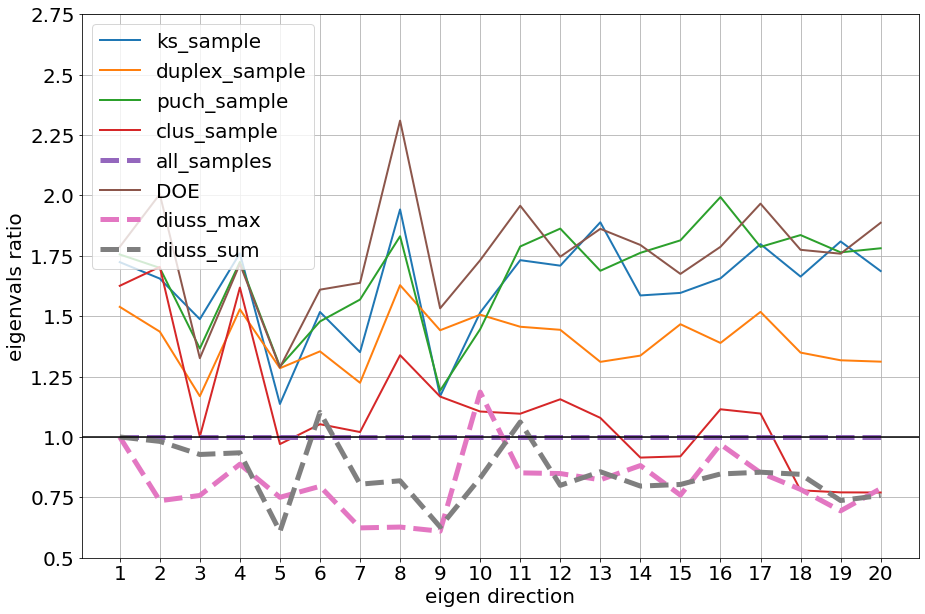

In [30]:
# --- visualize comparison svd
X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

# eigenvect comparison

print("determinant eigenvectors: \n")

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])
    eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))
    print(method_name,": ",np.round(eigen_vect_criterion,3))
    
    
# eigenval comparison

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (15,10))

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    if method_name =="diuss_max" or method_name =="diuss_sum" or method_name =="all_samples" :
        ax.plot(xticks,eigen_vals_ratio, Linewidth =5 , label = method_name, linestyle='dashed')
    else:
        ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)

        
    
ax.grid()
ax.axhline(y=1, c = "black")
ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)
ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.legend(fontsize = font_size)
plt.show()

## Cross validation PLSR model 

In [31]:
total_lv = 20
n_splits_cv = 10
n_shuffles = 1

In [32]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

<ipython-input-33-38b891b86173>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-33-38b891b86173>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-33-38b891b86173>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-33-38b891b86173>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

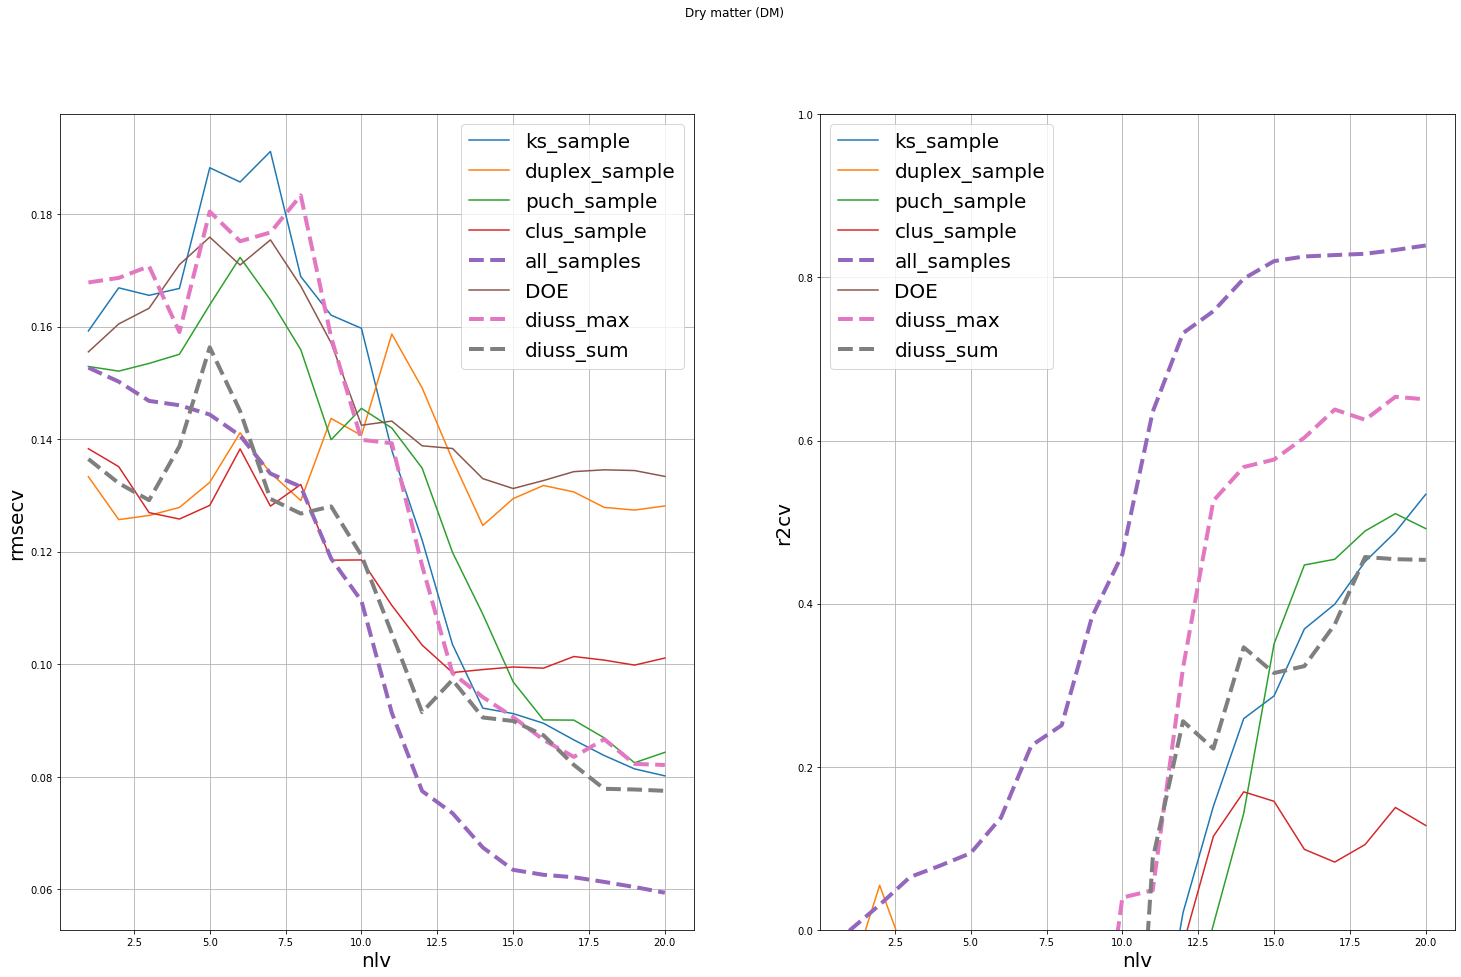

In [33]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])   

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Lactose"
fig.suptitle(y_name)

plt.show()

## PLSR

In [34]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= y_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-36-2c99d386248f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-2c99d386248f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-2c99d386248f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-2c99d386248f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

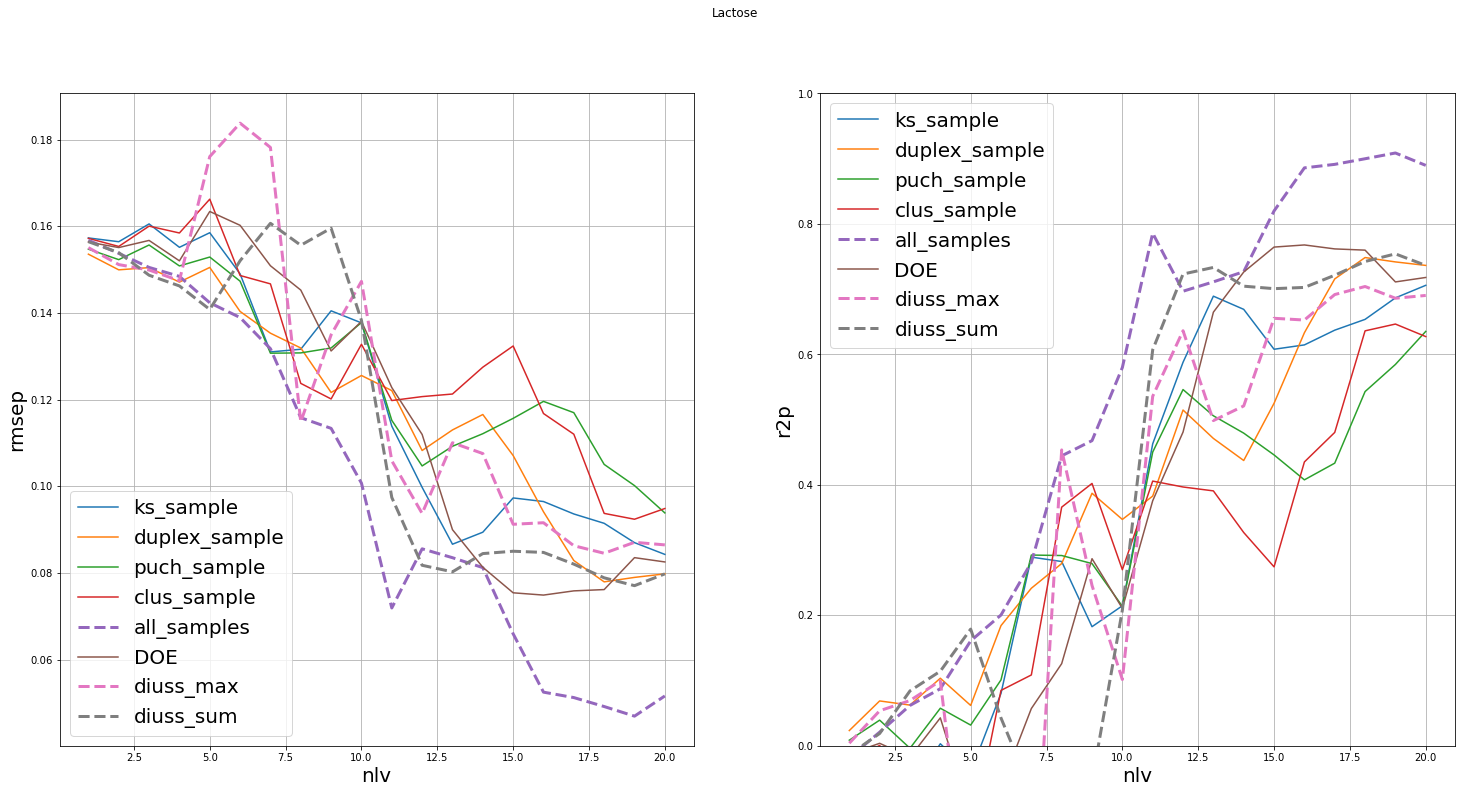

In [36]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,12))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[1].set_ylim([0,1])   

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Lactose"
fig.suptitle(y_name)

plt.show()
